<div style="color:#8b1538; font-size:35px;">Benchmark of stairway plot 2</div>

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.graphics.plot as plot
import sei.simulation.msprime as ms
import sei.sei as sei

<br>

# Stairway plot 2 inference

Problème avec stairway plot sur le cluster.

In [6]:
path = "./sei/inference/stairway_plot_v2.1.1/"
fichiers = [fichier for fichier in os.listdir(path) if os.path.isdir("{}{}".format(path, fichier)) 
            and fichier.split('-')[0] == 'stairway_decline']

for fichier in fichiers:
    stairway = pd.DataFrame(columns=['M0', 'M1', 'Ne', 'Year'])
    
    blueprint = "{}{}/stairway_inference/".format(path, fichier)
    
    # Extract data from the inference with stairway
    dico = f.read_stairway_final("{}/final/".format(blueprint))
    dico.update(f.read_stairway_summary("{}/stairway_inference.final.summary".format(blueprint)))
    
    # Keep track of parameters
    tau = float(fichier.split('=')[1].split('_')[0])
    kappa = float(fichier.split('=')[2])
    dico['Parameters'] = {'Tau': np.power(10, tau), 'Kappa': np.power(10, kappa)}
    
    # Summarize the data of the inference
    stairway = stairway.append(dico, ignore_index=True)
    
    # Convert pandas DataFrame data to json file
    stairway.to_json("./sei/inference/stairway_plot_v2.1.1/{}-all".format(fichier))
    
    # Remove file
    os.system("rm -rf ./sei/inference/stairway_plot_v2.1.1/{}".format(fichier))

'stairway_decline-tau=-3.3_kappa=-3.1'

<br>

<div style="color: #8b1538; font-size: 32px">1. Log-likelihood ratio test</div><br>

Likelihood ratio test lrt assess the godness fit of two model. It's allow you to test wheter adding parameters to models significantly increase the likelihood the model.

1. Likelihood ratio test

\begin{equation}
\large{ lrt = -2*\frac{L0}{L1} }
\end{equation}

with L0 the likelihood of m0 and L1 the likelihood of m1 <br>

2. Log-likelihood ratio test

\begin{equation}
\large{ log(lrt) = 2 * (log_{10}L1 - log_{10}L0) }
\end{equation}

with $log_{10}L0$ the log-likelihood of m0 and $log_{10}L1$ the log-likelihood of m1

<br>

**Models**

* M0 a n0-parameter model - the model with less parameters

* M1 a n1-parameter model - the model with more parameters

with n0 < n1 (number of parameters)

<br>

**Hypothesis**

* H0 the null hypothesis - adding the parameter(s) does not significantly increase the likelihood of the model

* H1 the alternative hypothesis - adding the parameter(s) significantly increase the likelihood of the model

<br>

**Decision rule**

* If p-value >= $\alpha$ then the test is insignificant and do not reject of H0

* If p-value < $\alpha$ then the test is significant and reject of H0

with $\alpha = 0.05$

<br>

**Degrees of freedom**

The difference in the number of parameters between M0 and M1, i.e. n1 - n0

> Load Data for stairway inference

In [2]:
data = f.export_stairway_files(model='decline', fold=False)

In [8]:
data.iloc[0]

M0            {'LL': [-967.4845888568, -1030.3196428092, -94...
M1            {'LL': [-100.8186991792, -97.1191464411, -92.2...
Ne                          [0.0702143523, 0.38541658100000004]
Year                      [0.0250339569, 0.0039738638000000005]
Parameters         {'Tau': 0.0039810717, 'Kappa': 0.0316227766}
Name: 0, dtype: object

In [54]:
def stairway_ll_test(data):
    key = [param for param in data.iloc[0]['Parameters'].keys()]
    df = pd.DataFrame(columns=[key[0], key[1], 'Positive hit'])

    # Pre-processing data
    for _, row in data.iterrows():
        # Extract parameters use to generate the observed SFS
        # Then compute log10 of these parameters
        dico = {}
        for param in row['Parameters'].keys():
            dico[param] = round(np.log10(row['Parameters'][param]), 2)
        
        # Compute log-likelihood ratio test
        dico['Positive hit'] = sum([sei.likelihood_ratio_test(ll_m0, ll_m1, dof=2) for ll_m0, ll_m1 in zip(row['M0']['LL'], row['M1']['LL'])])
        
        # Add to pandas DataFrame df
        df = df.append(dico, ignore_index=True)
        
    return df
    
ll_data = stairway_ll_test(data)

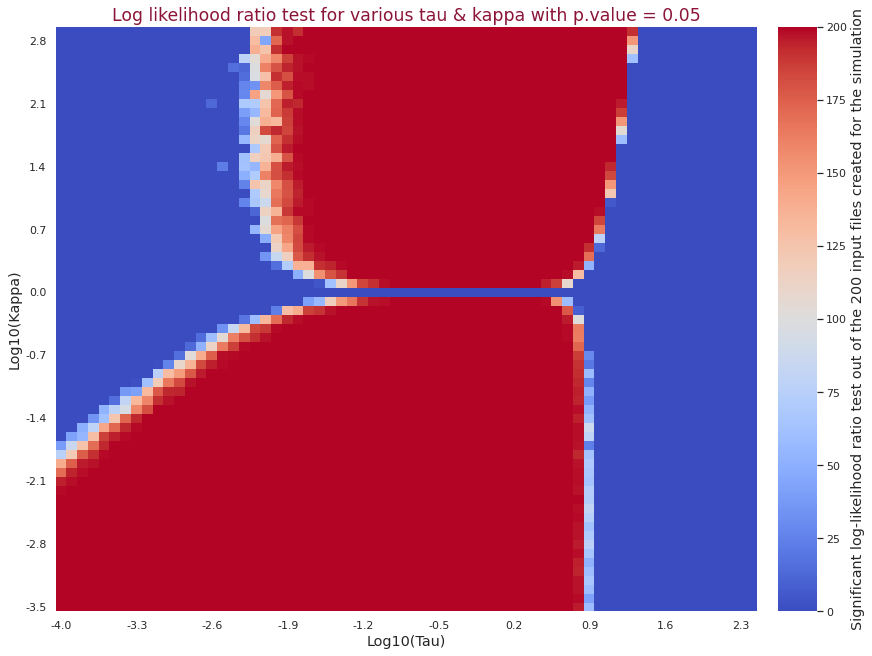

In [57]:
def plot_likelihood_stairway(data):
    # Set up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Pre-processing data
    df = data.pivot(index=data.columns[1], columns=data.columns[0], values='Positive hit')

    # Plot
    ax = sns.heatmap(df, cmap='coolwarm')

    # Heatmap x and y-axis personnalization
    plot.heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, 
                      cbar='Significant log-likelihood ratio test out of the 200 input files created for the simulation')

    # Title
    title = "Log likelihood ratio test for various tau & kappa with p.value = 0.05"
    plt.title(title, fontsize="x-large", color="#8b1538")

    plt.plot()


plot_likelihood_stairway(ll_data)

<br>

### Constan population

Stairway plot inference for some constant population with Ne = 1, Ne = 2, Ne = 10 & Ne = 100.

In [2]:
def sfs_cst_pop():
    # DataFrame
    data = pd.DataFrame(columns=['Parameters', 'SNPs', 'SFS observed'])
    
    # Parameters for the simulation
    params = {"sample_size": 20, "Ne": 0, "rcb_rate": 2e-2, "mu": 2e-2, "length": 1e5}
    
    for ne in [1, 2, 10]:
        params['Ne'] = ne
        
        # Constant scenario
        sfs = ms.msprime_simulation(model=ms.constant_model, params=params, debug=True)
        
        dico = {'Parameters': params.copy(), 'SNPs': [np.mean(sfs)], 'SFS observed': [sfs]}
        data = data.append(dico, ignore_index=True)
        
    return data


def inference_cst_pop(generate=False):
    if generate:
        data = sfs_cst_pop()
        data.to_json("./Data/Msprime/cst/SFS-cst")
    else:
        data = pd.read_json("./Data/Msprime/cst/SFS-cst")
        
    return data

In [3]:
simulation = inference_cst_pop(generate=False)

In [4]:
simulation

,Parameters,SNPs,SFS observed
0,"{'sample_size': 20, 'Ne': 1, 'rcb_rate': 0.02,...",[1462.1578947368],"[[7471, 4056, 2625, 1957, 1514, 1294, 1165, 10..."
1,"{'sample_size': 20, 'Ne': 2, 'rcb_rate': 0.02,...",[2986.1052631579],"[[15996, 8189, 5265, 4084, 3094, 2723, 2093, 2..."
2,"{'sample_size': 20, 'Ne': 10, 'rcb_rate': 0.02...",[15017.8421052632],"[[80377, 40178, 26825, 20229, 16309, 13161, 11..."


In [5]:
%%capture

for _, row in simulation.iterrows():
    sei.save_stairway_inference(row, 'cst')
    break

<br>

In [6]:
data = pd.read_json("./Data/Msprime/decline/SFS_decline-all")

Text(0.5, 1.0, "{'Tau': 0.0006309573, 'Kappa': 794.3282347243}")

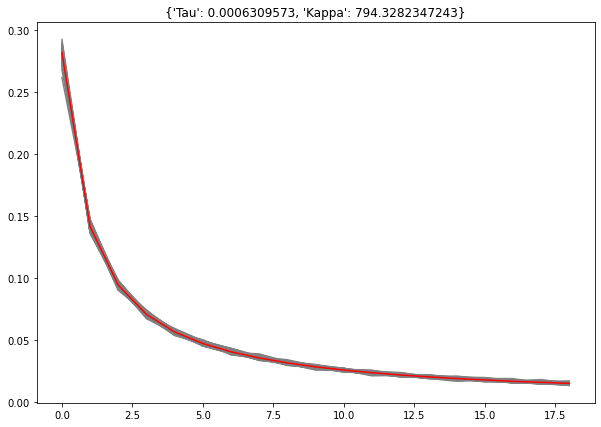

In [75]:
sfs = data.iloc[0]['SFS observed']
new = np.array([sum(spectrum) for spectrum in zip(*sfs)]) / len(sfs)

plt.figure(figsize=(10, 7))

for spectrum in sfs:
    plt.plot([ele/sum(spectrum) for ele in spectrum], color="grey")
plt.plot([ele/sum(new) for ele in new], color="red")
plt.title({k: v for k, v in data.iloc[0]['Parameters'].items() if k in ['Tau', 'Kappa']})